# Part 3. Modeling and visual analysis of IPA model

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## 1. Data preparation and collation

In [2]:
# Read the first CSV file
path1 = "../data/review/analysis/reviews_1.csv"
df1 = pd.read_csv(path1)

# Read and concatenate other CSV files
paths = [
    "../data/review/analysis/reviews_2.csv",
    "../data/review/analysis/reviews_3.csv",
    "../data/review/analysis/reviews_4.csv"
]
dfs = [df1]  # Add the first DataFrame to the list

for path in paths:
    df = pd.read_csv(path)
    dfs.append(df)  # Add each DataFrame to the list

# Vertically concatenate all DataFrames
merged_df = pd.concat(dfs, axis=0)

# Save as a new CSV file
output_path = "../data/review/analysis/reviews_merged.csv"
merged_df.to_csv(output_path, index=False)

In [3]:
# Read the reviews_merged.csv and topic_assignments.csv files
reviews_path = "../data/review/analysis/reviews_merged.csv"
topics_path = "../data/review/analysis/topics/topic_assignments.csv"

reviews_df = pd.read_csv(reviews_path)
topics_df = pd.read_csv(topics_path)

# Merge the DataFrames based on a common column
merged_df = pd.merge(reviews_df, topics_df, on="review_splitting")

# Save as a new CSV file
output_path = "../data/review/analysis/reviews_merged_with_topics.csv"
merged_df.to_csv(output_path, index=False)

## 2. Data analysis (calculation of importance and satisfaction)

In [4]:
df = pd.read_csv(output_path)
df.head(3)

,review,review_splitting,senti_score,polarity,senti_score_snownlp,polarity_snownlp,topic
0,"特别赞的一家商场,在王府井这个商场云集和大牌云集的地方,apm商场算是人气特别高的了,交通,...",特别 赞 一家 商场 王府井 商场 云集 大牌 云集 地方 apm 商场 算是 人气 特别 ...,18.25,P,1.000000,P,2
1,"LINLEE在王府井apm也开新店了,超级喜欢他们家的口味,和朋友逛街无意看到的,果断去买一...",LINLEE 王府井 apm 开 新店 超级 喜欢 家 口味 朋友 逛街 无意 果断 买 一...,10.30,P,1.000000,P,4
2,"北京apm,东城区商场热门榜第一名️,王府井大街号,环境,商场环境干净整齐,布局分明,美食购...",北京 apm 东城区 商场 热门 榜 第一名 ️ 王府井大街 号 环境 商场 环境 干净 整...,5.00,P,0.999969,P,1


In [5]:
# Count the number of each polarity for each topic
polarity_counts = df.groupby(["topic", "polarity"]).size()

# Convert the counts into a tabular form
table = polarity_counts.unstack()

# Print an example of the result
print(table)

polarity    I    N     P
topic                   
0          50   73   508
1          82   87  1004
2         733  956  5215
3          86  101   739
4          91  178   581


### Get the parameter : Importance

In [6]:
# Count the number of comments for each topic
topic_counts = df["topic"].value_counts()

# Calculate the percentages
total_count = len(df)
topic_percentages = round(topic_counts / total_count * 100, 2)

# Add the percentage sign
topic_percentages_with_sign = topic_percentages.astype(str) + '%'

# Print an example of the result
print("评论数量:")
print(topic_counts)
print("\n百分比:")
print(topic_percentages_with_sign)

评论数量:
2    6904
1    1173
3     926
4     850
0     631
Name: topic, dtype: int64

百分比:
2    65.85%
1    11.19%
3     8.83%
4     8.11%
0     6.02%
Name: topic, dtype: object


### Get the parameter : Performance

In [7]:
# Calculate the average sentiment scores by topic
average_scores_by_topic = df.groupby("topic")["senti_score"].mean()

# Print the average scores by topic
print(average_scores_by_topic)

topic
0    4.557338
1    4.744689
2    4.088046
3    4.863661
4    2.931059
Name: senti_score, dtype: float64


### Get the table of importance and performance relationship of each topics

In [8]:
# Convert the two Series objects to DataFrames
df_topic_percentages = pd.DataFrame({"Importance": topic_percentages.values}, index=topic_percentages.index)
df_average_scores = pd.DataFrame({"Performance": average_scores_by_topic.values}, index=average_scores_by_topic.index)

# Horizontally concatenate the DataFrames
df_merged = pd.concat([df_topic_percentages, df_average_scores], axis=1)

# Print the merged DataFrame
df_merged_sorted = df_merged.sort_index()
print(df_merged_sorted)

   Importance  Performance
0        6.02     4.557338
1       11.19     4.744689
2       65.85     4.088046
3        8.83     4.863661
4        8.11     2.931059


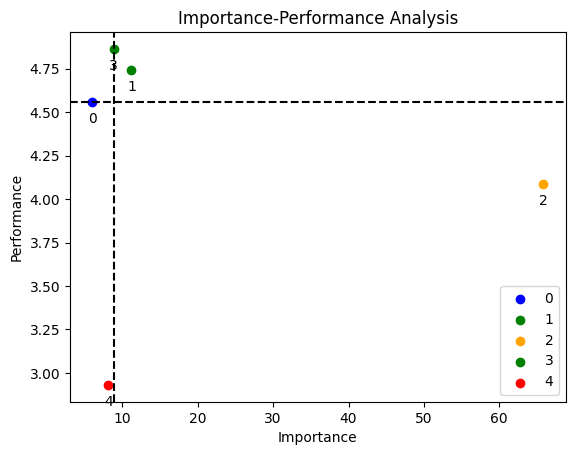

In [9]:
# Define the thresholds for the four quadrants
importance_threshold = df_merged_sorted["Importance"].median()
performance_threshold = df_merged_sorted["Performance"].median()

# Create a scatter plot with four quadrants
fig, ax = plt.subplots()

# Plot the data points in the four quadrants
for index, row in df_merged_sorted.iterrows():
    importance = row["Importance"]
    performance = row["Performance"]
    label = index
    
    if importance >= importance_threshold and performance >= performance_threshold:
        # Quadrant 1: High Importance, High Performance
        ax.scatter(importance, performance, marker="o", color="green", label=label)
    elif importance < importance_threshold and performance >= performance_threshold:
        # Quadrant 2: Low Importance, High Performance
        ax.scatter(importance, performance, marker="o", color="blue", label=label)
    elif importance < importance_threshold and performance < performance_threshold:
        # Quadrant 3: Low Importance, Low Performance
        ax.scatter(importance, performance, marker="o", color="red", label=label)
    else:
        # Quadrant 4: High Importance, Low Performance
        ax.scatter(importance, performance, marker="o", color="orange", label=label)
    
    # Add text labels to the data points
    ax.annotate(index, (importance, performance), textcoords="offset points", xytext=(0,-15), ha='center')

# Plot the boundaries of the quadrants
ax.axvline(x=importance_threshold, color="black", linestyle="--")
ax.axhline(y=performance_threshold, color="black", linestyle="--")

# Set the axis labels and title
ax.set_xlabel("Importance")
ax.set_ylabel("Performance")
ax.set_title("Importance-Performance Analysis")

# Add a legend
ax.legend()

# Save the figure as a PNG file
plt.savefig("../images/IPA_analysis/demo/IPA_analysis.svg", dpi=300)

# Show the plot
plt.show()